# Opdracht 3 Soort van YOLO

In deze opdracht wordt een neuraal netwerk getraind met behulp van het objectdetectie-algoritme YOLO (You Only Look Once) om tumoren te detecteren en lokaliseren in medische afbeeldingen. Het proces begint met de voorbereiding van de dataset, waarbij de annotaties van tumoren worden omgezet naar het YOLO-formaat. Dit formaat vereist dat elke afbeelding een bijbehorend tekstbestand heeft met daarin genormaliseerde coördinaten van de bounding boxes en een klassewaarde. Omdat de dataset slechts één klasse bevat (tumor), is de klassewaarde altijd 1. Vervolgens worden de afbeeldingen en annotaties verdeeld over een trainings- en validatieset, en georganiseerd in een specifieke directory-structuur die geschikt is voor YOLO.

Een configuratiebestand (dataset.yaml) wordt aangemaakt met daarin de paden naar de trainings- en validatiesets, het aantal klassen (1) en de klassenaam ('tumor'). Dit bestand wordt gebruikt bij het trainen van het YOLO-model. Tijdens de training wordt de parameter single_cls op True gezet, omdat de taak een binaire classificatie betreft. Het model wordt getraind op een dataset van afbeeldingen en bijbehorende annotaties, waarbij de prestaties worden geëvalueerd op de validatieset. Na afloop van de training wordt het beste model opgeslagen als een .pt-bestand in de outputmap van YOLO.

Tot slot wordt het getrainde model gebruikt om tumoren te voorspellen in nieuwe, ongeziene afbeeldingen. De resultaten van deze voorspellingen worden gevisualiseerd door de voorspelde bounding boxes op de afbeeldingen te plotten. Het doel van de opdracht is om een volledig functioneel objectdetectiemodel te ontwikkelen dat in staat is tumoren nauwkeurig te identificeren en te lokaliseren in medische beelddata.

### Laad libraries

In [2]:
import os
import random
import shutil
from PIL import Image

import pandas as pd
from ultralytics import YOLO
import matplotlib.pyplot as plt

### Data omzetten naar YOLO-formaat

In [2]:
def convert_to_yolo_format(coords_file, images_folder, output_folder):
    """
    Converteert annotaties van een CSV-bestand naar YOLO-formaat.

    Parameters:
    - coords_file (str): Pad naar het CSV-bestand met annotaties.
    - images_folder (str): Map met afbeeldingsbestanden.
    - output_folder (str): Map om de YOLO-annotaties op te slaan.

    Returns:
    None
    """
    # Maak output map aan als die nog niet bestaat
    os.makedirs(output_folder, exist_ok=True)

    # Laad annotaties
    coords = pd.read_csv(
        coords_file, header=None, names=["image_id", "xmin", "ymin", "xmax", "ymax"]
    )

    for image_id in coords["image_id"].unique():
        # Selecteer alle annotaties voor een afbeelding
        image_coords = coords[coords["image_id"] == image_id]

        # Bereken de afmetingen van de afbeelding
        image_path = os.path.join(images_folder, f"{image_id}.jpeg")
        if not os.path.exists(image_path):
            print(f"Afbeelding {image_path} niet gevonden.")
            continue

        with Image.open(image_path) as img:
            width, height = img.size

        # Genereer YOLO-annotaties
        yolo_annotations = []
        for _, row in image_coords.iterrows():
            x_center = ((row["xmin"] + row["xmax"]) / 2) / width
            y_center = ((row["ymin"] + row["ymax"]) / 2) / height
            bbox_width = (row["xmax"] - row["xmin"]) / width
            bbox_height = (row["ymax"] - row["ymin"]) / height
            yolo_annotations.append(
                f"1 {x_center:.6f} {y_center:.6f} {bbox_width:.6f} {bbox_height:.6f}"
            )

        # Schrijf annotaties naar bestand
        annotation_path = os.path.join(output_folder, f"{image_id}.txt")
        with open(annotation_path, "w") as f:
            f.write("\n".join(yolo_annotations))


coords_file = "../data/coords-idc.txt"
images_folder = "../data/complete_images"
output_folder = "../data/yolo_labels"

convert_to_yolo_format(coords_file, images_folder, output_folder)

### Directory-structuur creëren

In [3]:
def create_dataset_structure(images_folder, labels_folder, output_folder, train_ratio=0.8):
    """
    Creëert een gestructureerde dataset met een training- en validatieset.

    Parameters:
    - images_folder (str): Map met afbeeldingsbestanden.
    - labels_folder (str): Map met YOLO-annotaties.
    - output_folder (str): Doelmap voor gestructureerde dataset.
    - train_ratio (float): Ratio van training-data tot validatie-data.

    Returns:
    None
    """
    # Maak mapstructuur
    for split in ["train", "val"]:
        os.makedirs(os.path.join(output_folder, "images", split), exist_ok=True)
        os.makedirs(os.path.join(output_folder, "labels", split), exist_ok=True)

    # Verdeel data in training- en validatiesets
    image_files = [f for f in os.listdir(images_folder) if f.endswith(".jpeg")]
    random.shuffle(image_files)
    train_split = int(len(image_files) * train_ratio)

    splits = {
        "train": image_files[:train_split],
        "val": image_files[train_split:]
    }

    for split, files in splits.items():
        for image_file in files:
            # Verplaats afbeelding
            src_image = os.path.join(images_folder, image_file)
            dest_image = os.path.join(output_folder, "images", split, image_file)
            shutil.copy(src_image, dest_image)

            # Verplaats corresponderend label
            label_file = image_file.replace(".jpeg", ".txt")
            src_label = os.path.join(labels_folder, label_file)
            dest_label = os.path.join(output_folder, "labels", split, label_file)
            if os.path.exists(src_label):
                shutil.copy(src_label, dest_label)


images_folder = "../data/complete_images"
labels_folder = "../data/yolo_labels"
output_folder = "../data/dataset"

create_dataset_structure(images_folder, labels_folder, output_folder)

### YOLO-configuratiebestand

Er is een configuratie-bestand dataset.yaml gemaakt met daarin de volgende gegevens

train: /path/to/dataset/images/train

val: /path/to/dataset/images/val

nc: 1  # aantal klassen

names: ['tumor']  # lijst van klasse-namen

### Model trainen

In [4]:
# Gebruik YOLO om een model te trainen
def train_yolo_model(model_path, data_path, epochs=20, single_class=True, amp=False, verbose=True):
    """
    Trains a YOLO model using the specified parameters.

    Parameters:
    - model_path (str): Path to the YOLO model.
    - data_path (str): Path to the dataset YAML file.
    - epochs (int): Number of training epochs. Default is 3.
    - single_class (bool): Whether to train for a single class. Default is True.
    - amp (bool): Enable Automatic Mixed Precision. Default is False.
    - verbose (bool): Enable verbose logging. Default is True.

    Returns:
    None
    """
    model = YOLO(model_path)
    model.train(data=data_path, epochs=epochs, single_cls=single_class, amp=amp, verbose=verbose)


# Model en dataset configuratie
model_path = "yolov8n.pt"
data_path = "dataset.yaml"
train_yolo_model(model_path, data_path)

New https://pypi.org/project/ultralytics/8.3.52 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.51  Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8n.pt, data=dataset.yaml, epochs=20, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train34, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=True, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=False, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, sa

train: Scanning C:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\data\dataset\labels\train... 279 images, 0 backgrounds, 1 corrupt: 100%|██████████| 279/279 [00:00<00:00, 788.74it/s]

train: WARNING  C:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\data\dataset\images\train\12906.jpeg: ignoring corrupt image/label: negative label values [  -0.014904    -0.35914   -0.036478    -0.22465    -0.38829]
train: New cache created: C:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\data\dataset\labels\train.cache



val: Scanning C:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\data\dataset\labels\val... 259 images, 0 backgrounds, 1 corrupt: 100%|██████████| 259/259 [00:00<00:00, 475.72it/s]

val: WARNING  C:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\data\dataset\images\val\12906.jpeg: ignoring corrupt image/label: negative label values [  -0.014904    -0.35914   -0.036478    -0.22465    -0.38829]


val: New cache created: C:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\data\dataset\labels\val.cache
Plotting labels to runs\detect\train34\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.002, momentum=0.9) with parameter groups 57 weight(decay=0.0), 64 weight(decay=0.0005), 63 bias(decay=0.0)
TensorBoard: model graph visualization added 
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train34
Starting training for 20 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       1/20      4.31G      2.711      3.684      2.459         18        640: 100%|██████████| 18/18 [00:07<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  1.93it/s]

                   all        258        657    0.00453      0.534      0.033    0.00985



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       2/20       4.3G      2.503      3.073      2.083         25        640: 100%|██████████| 18/18 [00:05<00:00,  3.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        258        657    0.00549      0.647     0.0803     0.0266



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       3/20      4.31G      2.534      2.963       1.99         23        640: 100%|██████████| 18/18 [00:04<00:00,  3.60it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.24it/s]


                   all        258        657      0.136     0.0502     0.0373    0.00958

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       4/20       4.3G       2.37      2.784       1.96         18        640: 100%|██████████| 18/18 [00:04<00:00,  3.75it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.39it/s]

                   all        258        657      0.163      0.154     0.0601     0.0192



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       5/20       4.3G      2.484      2.788      2.001         12        640: 100%|██████████| 18/18 [00:04<00:00,  3.85it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.27it/s]

                   all        258        657     0.0942      0.163     0.0412     0.0127



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       6/20       4.3G      2.479      2.757      1.948         17        640: 100%|██████████| 18/18 [00:04<00:00,  3.77it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        258        657     0.0852      0.148     0.0464     0.0129



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       7/20       4.3G      2.436      2.669      1.996         27        640: 100%|██████████| 18/18 [00:04<00:00,  3.74it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.49it/s]

                   all        258        657      0.119      0.151     0.0579      0.018



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       8/20       4.3G      2.366      2.565      1.875         20        640: 100%|██████████| 18/18 [00:04<00:00,  3.88it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.44it/s]

                   all        258        657      0.208      0.142     0.0872       0.03



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


       9/20       4.3G      2.347      2.545      1.847         36        640: 100%|██████████| 18/18 [00:04<00:00,  3.78it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

                   all        258        657      0.296      0.213      0.164     0.0593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      10/20       4.3G      2.359      2.499      1.895         28        640: 100%|██████████| 18/18 [00:04<00:00,  3.93it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.48it/s]

                   all        258        657      0.296      0.236      0.199     0.0652


Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      11/20      4.28G      2.376      2.696      1.938         20        640: 100%|██████████| 18/18 [00:05<00:00,  3.16it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.41it/s]

                   all        258        657      0.295      0.242      0.196     0.0735



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      12/20      4.26G      2.342      2.641      1.906         12        640: 100%|██████████| 18/18 [00:04<00:00,  3.73it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.56it/s]

                   all        258        657      0.282      0.231      0.175     0.0618



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      13/20      4.28G      2.294      2.614      1.914         15        640: 100%|██████████| 18/18 [00:04<00:00,  3.84it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.65it/s]

                   all        258        657      0.331      0.262      0.226     0.0841



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      14/20      4.28G      2.232       2.55      1.853          7        640: 100%|██████████| 18/18 [00:04<00:00,  4.09it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all        258        657      0.341      0.271      0.236     0.0975



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      15/20      4.27G      2.257      2.532      1.878         16        640: 100%|██████████| 18/18 [00:04<00:00,  4.13it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.55it/s]

                   all        258        657      0.311      0.263       0.23     0.0945



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      16/20      4.28G      2.253      2.503      1.874         13        640: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.47it/s]

                   all        258        657      0.361      0.294      0.265      0.106



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      17/20      4.28G      2.198      2.459      1.815         15        640: 100%|██████████| 18/18 [00:04<00:00,  4.01it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.54it/s]

                   all        258        657      0.444      0.285      0.289       0.11



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      18/20      4.28G      2.202      2.434      1.815         15        640: 100%|██████████| 18/18 [00:04<00:00,  4.08it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.71it/s]

                   all        258        657      0.409        0.3      0.282      0.104



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      19/20      4.27G      2.175      2.423      1.824         21        640: 100%|██████████| 18/18 [00:04<00:00,  3.72it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.40it/s]

                   all        258        657      0.428      0.306      0.296      0.118



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      20/20      4.27G      2.143      2.389      1.801         13        640: 100%|██████████| 18/18 [00:04<00:00,  3.97it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:03<00:00,  2.59it/s]

                   all        258        657      0.413      0.323      0.302      0.122



20 epochs completed in 0.069 hours.
Optimizer stripped from runs\detect\train34\weights\last.pt, 6.2MB
Optimizer stripped from runs\detect\train34\weights\best.pt, 6.2MB

Validating runs\detect\train34\weights\best.pt...
Ultralytics 8.3.51  Python-3.12.7 torch-2.5.1+cu118 CUDA:0 (NVIDIA GeForce RTX 4060 Laptop GPU, 8188MiB)
Model summary (fused): 168 layers, 3,005,843 parameters, 0 gradients, 8.1 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 9/9 [00:04<00:00,  2.18it/s]


                   all        258        657      0.414      0.322      0.302      0.122
Speed: 0.3ms preprocess, 3.3ms inference, 0.0ms loss, 3.9ms postprocess per image
Results saved to runs\detect\train34


### Voorspellingen doen

In [7]:
def make_predictions_yolov5(model_path, test_images_folder, output_folder):
    """
    Perform predictions using a YOLOv5 model.
    
    Parameters:
        model_path (str): Path to the trained YOLO model weights.
        test_images_folder (str): Folder containing test images.
        output_folder (str): Folder to save predictions.
    
    Returns:
        None
    """
    # Initialize YOLO model
    model = YOLO(model_path)
    
    os.makedirs(output_folder, exist_ok=True)
    
    # Run predictions
    results = model.predict(
        source=test_images_folder,
        stream=False,  
        save_txt=True,  
        save_conf=True,  
        save=True, 
        project=output_folder,  
        exist_ok=True,  
        conf = 0.25
    )
    
    print("Predictions completed. Saved to:", output_folder)

model_path = "../notebooks/runs/detect/train34/weights/best.pt"
test_images = "../data/dataset/images/val"
output_folder = "predictions"

make_predictions_yolov5(model_path, test_images, output_folder)


image 1/259 c:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\notebooks\..\data\dataset\images\val\10253.jpeg: 512x640 1 tumor, 14.1ms
image 2/259 c:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\notebooks\..\data\dataset\images\val\10254.jpeg: 512x640 1 tumor, 18.0ms
image 3/259 c:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\notebooks\..\data\dataset\images\val\10255.jpeg: 544x640 1 tumor, 11.8ms
image 4/259 c:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\notebooks\..\data\dataset\images\val\10256.jpeg: 480x640 (no detections), 24.2ms
image 5/259 c:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\notebooks\..\data\dataset\images\val\10257.jpeg: 576x640 (no detections), 12.5ms
image 6/259 c:\Users\isabe\Documents\Hanze\jaar_3_new\kw2\modelleren_van_kanker\casus_d\notebooks\..\data\dataset\images\val\10258.jpeg: 544x640 1 tumor, 27.8ms
image 7/259 c:\Us

## Model evaluatie

### Visualisations

De onderstaande afbeelding toont een voorspelling van het model, waarbij de confidence score aangeeft hoe zeker het model is. Alleen voorspellingen met een score van 25% of hoger worden weergegeven. Deze drempel is gekozen als een goed compromis tussen het minimaliseren van foutieve detecties en het behouden van relevante voorspellingen.

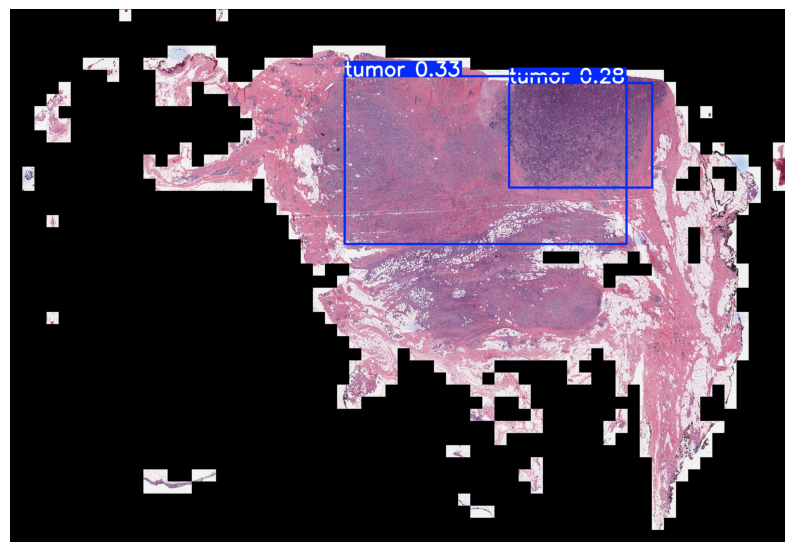

In [15]:
tumor_image = "../notebooks/predictions/predict/12242.jpg"
image = Image.open(tumor_image)

plt.figure(figsize=(10, 9))
plt.imshow(image)
plt.axis('off') 
plt.show()

De afbeelding hieronder bevat de resulaten. Zowel de training- als validatieloss nemen consistent af, wat duidt op een betere fit van het model op de data. Tegelijkertijd vertonen de waarden, zoals precisie, recall en mAP (50 en 50-95), een stijgende trend, wat wijst op een toename in de nauwkeurigheid en generalisatie van het model bij voorspellingen. Deze resultaten suggereren dat het model effectief leert zonder duidelijke tekenen van overfitting.

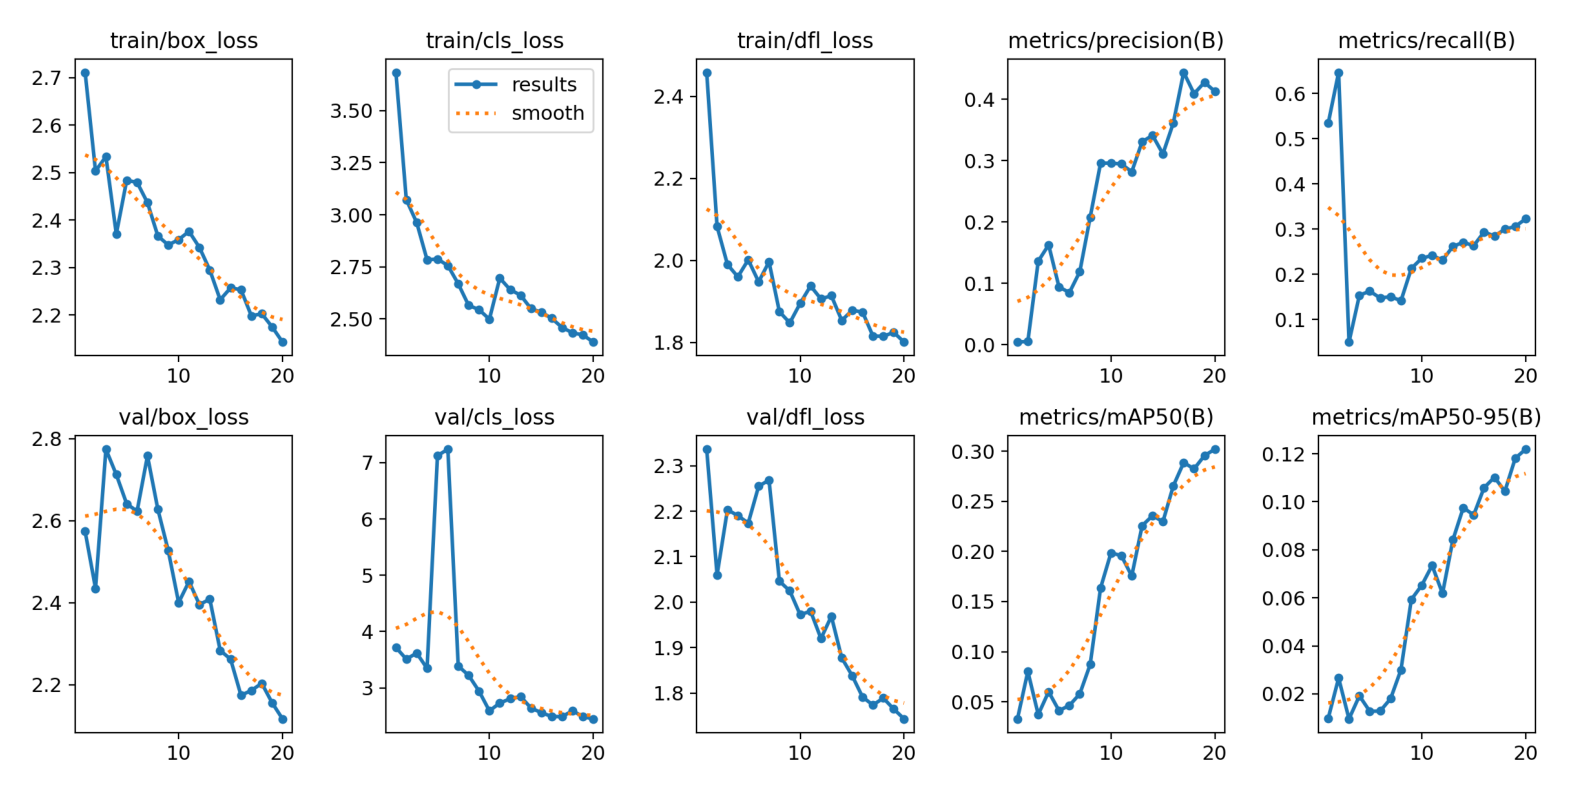

In [16]:
result_image = "../notebooks/runs/detect/train34/results.png"
image = Image.open(result_image)

plt.figure(figsize=(20, 18))
plt.imshow(image)
plt.axis('off') 
plt.show()

### Conclusion 

De resultaten wijzen op ruimte voor verbetering. Aanbevolen is:

- Een groter YOLO-model gebruiken.
- Meer train- en testdata verzamelen.
- Het aantal epochs verhogen (meer dan 20).
- Nauwkeurigere annotaties toepassen, zoals cellulaire contouren in plaats van vierkanten.
- Tumoren handmatig markeren voor hogere precisie.
- Een test- en validatiesplit toepassen in plaats van slechts één van beide.

Deze aanpassingen kunnen de modelprestatie verder optimaliseren.